In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import time
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from scipy.stats import zscore
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
import torch 
from torch import nn
from torch.optim import Adam
from sklearn.model_selection import ParameterGrid
import warnings

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Is CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Device Name:", torch.cuda.get_device_name(0))
    print("CUDA Version:", torch.version.cuda)
    print("Torch CUDA Version:", torch.version.cuda)
    print("Torch Version:", torch.__version__)
else:
    print("CUDA is not available.")


Is CUDA available: True
Device Name: NVIDIA GeForce RTX 4070 Laptop GPU
CUDA Version: 12.4
Torch CUDA Version: 12.4
Torch Version: 2.5.1+cu124


In [4]:
start_time = time.time()
complaints_cfpb = pd. DataFrame()

for chunk in pd.read_csv('complaints.csv', chunksize=400000):
    print('Number of chunks read: ', chunk.shape)
    complaints_cfpb = pd.concat([complaints_cfpb, chunk])

print("Time taken to read the data: ", time.time() - start_time)

print("Shape of the dataframe: ", complaints_cfpb.shape)

Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (335939, 18)
Time taken to read the data:  34.83057355880737
Shape of the dataframe:  (6335939, 18)


In [5]:
complaints_cfpb['Date received'] = pd.to_datetime(complaints_cfpb['Date received'], errors='coerce')
complaints_cfpb['Date sent to company'] = pd.to_datetime(complaints_cfpb['Date sent to company'], errors='coerce')

In [6]:
for col in complaints_cfpb.select_dtypes(include='object').columns:
    complaints_cfpb[col] = complaints_cfpb[col].astype('category')

In [7]:
complaints_cfpb = complaints_cfpb[complaints_cfpb['Date received'] >= '2023-01-01']

In [8]:
print("Minimum date in the dataset: ", complaints_cfpb['Date received'].min())
print("Maximum date in the dataset: ", complaints_cfpb['Date received'].max())

Minimum date in the dataset:  2023-01-01 00:00:00
Maximum date in the dataset:  2024-10-06 00:00:00


In [9]:
date_range = pd.date_range(start='2023-01-01', end='2024-10-06')
missing_dates = date_range.difference(complaints_cfpb['Date received'])

if missing_dates.empty:
    print("No missing dates in the dataset.")
else:
    print("Missing dates: ", missing_dates)

No missing dates in the dataset.


In [10]:
time_series = complaints_cfpb.groupby('Date received').size()
time_series = time_series.reindex(pd.date_range(start='2023-01-01', end='2024-10-06'), fill_value=0)
time_series.index.name = 'Date'
time_series = time_series.rename('Complaint Count')

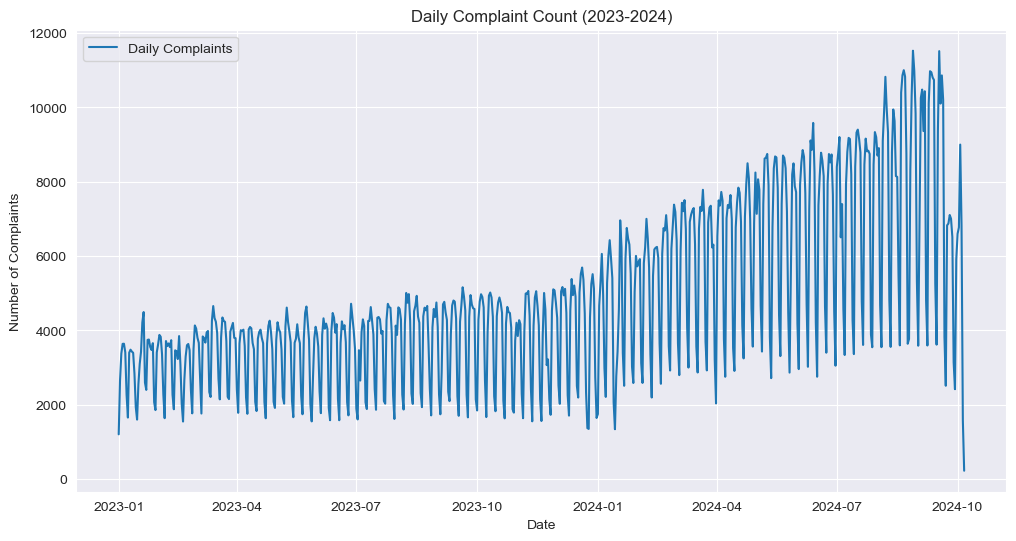

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Daily Complaints')
plt.title('Daily Complaint Count (2023-2024)')
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.legend()
plt.grid(True)
plt.show()

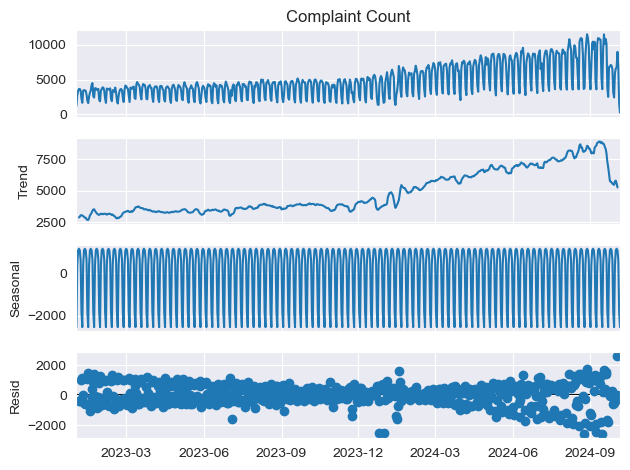

In [12]:
decompose_result = seasonal_decompose(time_series, model='additive', period=7)
fig = decompose_result.plot()

for ax in fig.axes[:-1]:  
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  
    ax.tick_params(axis='x', rotation=45) 

plt.tight_layout()
plt.show()

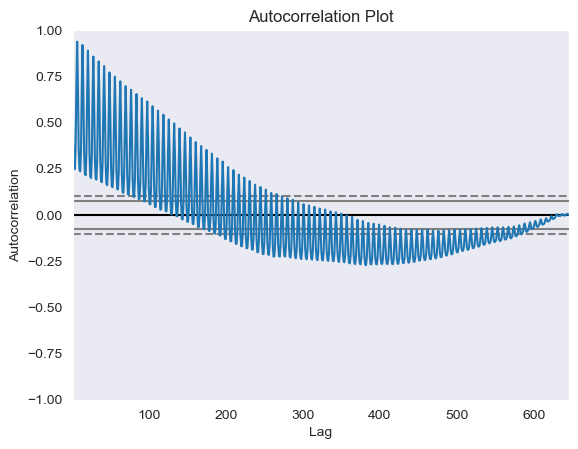

In [13]:
autocorrelation_plot(time_series)
plt.title('Autocorrelation Plot')
plt.show()

In [14]:
result = adfuller(time_series)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary. Differencing may be needed.")

ADF Statistic: -1.0997843065772355
p-value: 0.7151579135448125
The series is not stationary. Differencing may be needed.


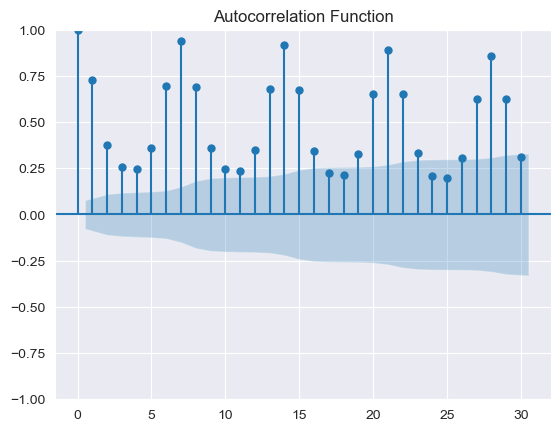

In [15]:
plot_acf(time_series, lags=30)  # Show up to 30 lags
plt.title("Autocorrelation Function")
plt.show()

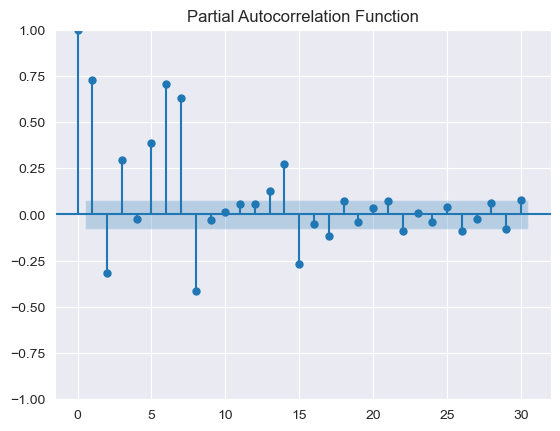

ADF Statistic: -4.086873444213831
p-value: 0.0010180594953903038
The differenced series is stationary.


In [16]:
plot_pacf(time_series, lags=30)
plt.title("Partial Autocorrelation Function")
plt.show()
diff_series = time_series.diff(7).dropna()

result = adfuller(diff_series)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] < 0.05:
    print("The differenced series is stationary.")
else:
    print("Further differencing may be required.")

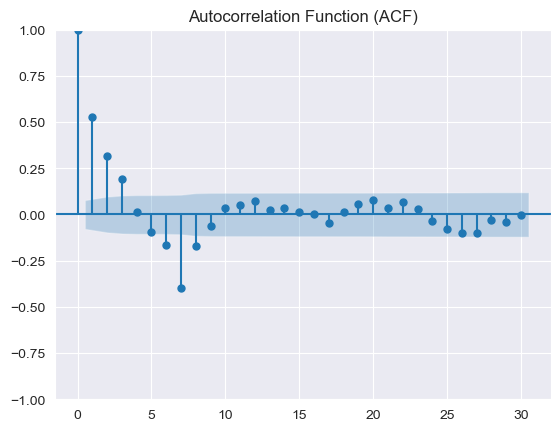

In [17]:
plot_acf(diff_series, lags=30)  # Adjust lags as needed
plt.title("Autocorrelation Function (ACF)")
plt.show()

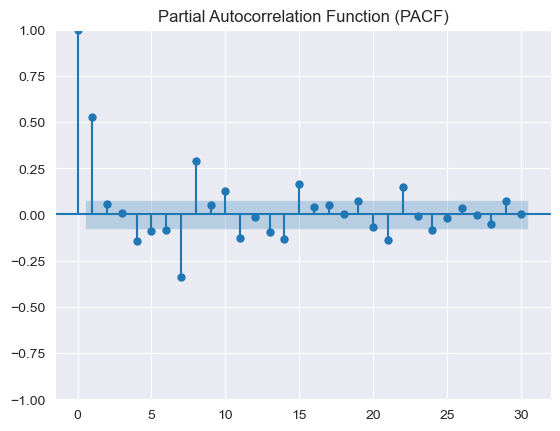

In [18]:
plot_pacf(diff_series, lags=30)
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()

In [19]:
z_scores = zscore(time_series)
outliers = abs(z_scores) > 3  # Z-score threshold for outliers
print("Number of Outliers:", sum(outliers))

Number of Outliers: 0


# **Baseline ARIMA Model**

In [20]:
def arima_model(data, p, d, q, forecast_steps):
    arima_model = ARIMA(data, order=(p, d, q))
    arima_fit = arima_model.fit()
    
    print(arima_fit.summary())
    
    forecast = arima_fit.forecast(steps=forecast_steps)

    plt.figure(figsize=(12, 6))
    plt.plot(data, label='Historical Data')
    plt.plot(pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='D')[1:], forecast, color='green', label='Forecast')
    plt.title('ARIMA Model Forecast (Next 6 Months)')
    plt.xlabel('Date')
    plt.ylabel('Number of Complaints')
    plt.legend()
    plt.grid(True)
    plt.show()

    return forecast

                               SARIMAX Results                                
Dep. Variable:        Complaint Count   No. Observations:                  645
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5664.160
Date:                Sun, 08 Dec 2024   AIC                          11334.320
Time:                        17:17:15   BIC                          11347.723
Sample:                    01-01-2023   HQIC                         11339.521
                         - 10-06-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4567      0.099     -4.605      0.000      -0.651      -0.262
ma.L1          0.8164      0.053     15.511      0.000       0.713       0.920
sigma2      2.887e+06    1.3e+05     22.120      0.0

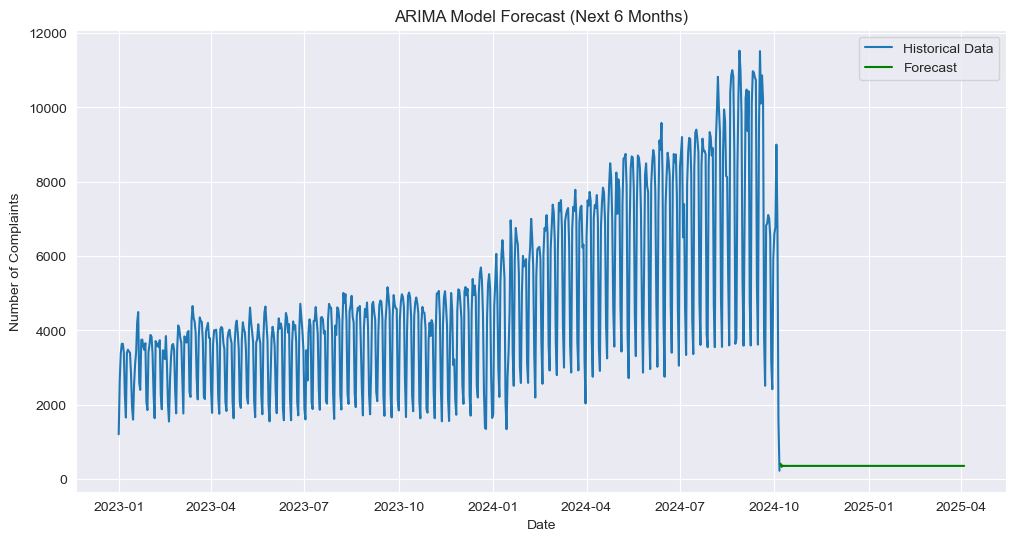

2024-10-07   418.27
2024-10-08   331.82
2024-10-09   371.31
2024-10-10   353.27
2024-10-11   361.51
              ...  
2025-03-31   358.93
2025-04-01   358.93
2025-04-02   358.93
2025-04-03   358.93
2025-04-04   358.93
Freq: D, Name: predicted_mean, Length: 180, dtype: float64

In [21]:
arima_model(time_series, 1, 1, 1, forecast_steps=180)

# **Fine-tuned ARIMA Model**

In [22]:
def fine_tune_arima_model(data, p_range, d_range, q_range, forecast_steps):
    pdq_combinations = list(itertools.product(p_range, d_range, q_range))
    best_aic = float('inf')
    best_params = None

    print("Performing Grid Search for ARIMA Parameters...")
    for param in pdq_combinations:
        try:
            arima_model = ARIMA(data, order=param)
            model_fit = arima_model.fit()
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_params = param
        except Exception as e:
            continue

    print(f"Best ARIMA Parameters: {best_params} with AIC: {best_aic}")

    best_arima_model = ARIMA(data, order=best_params)
    best_arima_fit = best_arima_model.fit()
    
    print(best_arima_fit.summary())

    forecast = best_arima_fit.forecast(steps=forecast_steps)

    plt.figure(figsize=(12, 6))
    plt.plot(data, label='Historical Data')
    plt.plot(pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='D')[1:], forecast, color='green', label='Forecast')
    plt.title('ARIMA Model Forecast (Next 6 Months)')
    plt.xlabel('Date')
    plt.ylabel('Number of Complaints')
    plt.legend()
    plt.grid(True)
    plt.show()

    return forecast, model_fit

Performing Grid Search for ARIMA Parameters...
Best ARIMA Parameters: (4, 1, 3) with AIC: 10473.516616806008
                               SARIMAX Results                                
Dep. Variable:        Complaint Count   No. Observations:                  645
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -5228.758
Date:                Sun, 08 Dec 2024   AIC                          10473.517
Time:                        17:17:30   BIC                          10509.258
Sample:                    01-01-2023   HQIC                         10487.386
                         - 10-06-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8172      0.043     18.861      0.000       0.732       0.902
ar.L2         -1.2473 

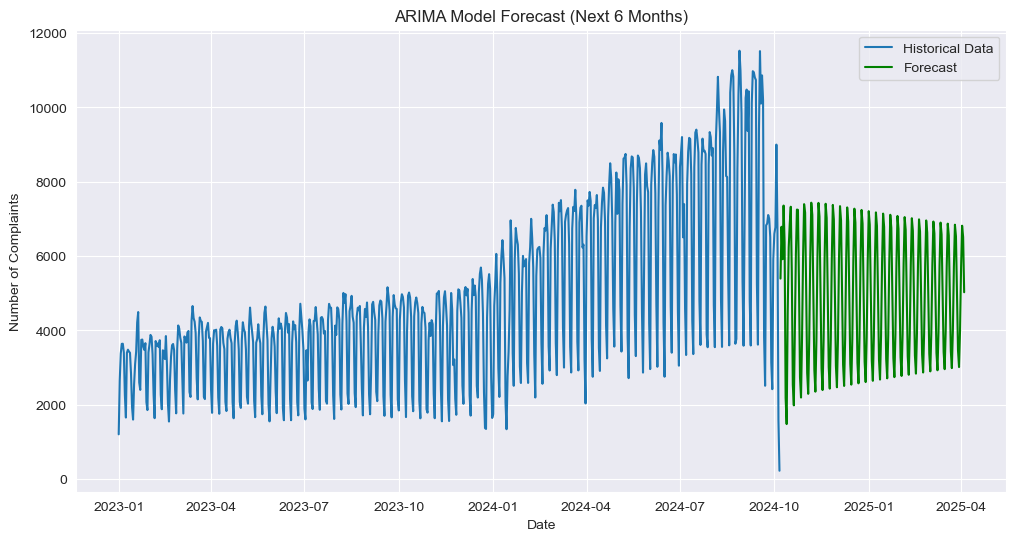

In [23]:
_, model_fit = fine_tune_arima_model(time_series, range(0, 5), range(0, 2), range(0, 5), forecast_steps=180)

In [24]:
def residual_analysis(model_fit):
    residuals = model_fit.resid

    plt.figure(figsize=(12, 6))
    plt.plot(residuals, label="Residuals")
    plt.axhline(0, linestyle="--", color="red")
    plt.title("Residuals of ARIMA Model")
    plt.legend()
    plt.grid(True)
    plt.show()

    plot_acf(residuals, lags=30)
    plt.title("ACF of Residuals")
    plt.show()

    sns.histplot(residuals, kde=True, color="blue", bins=20)
    plt.title("Distribution of Residuals")
    plt.xlabel("Residuals")
    plt.grid(True)
    plt.show()

    return residuals

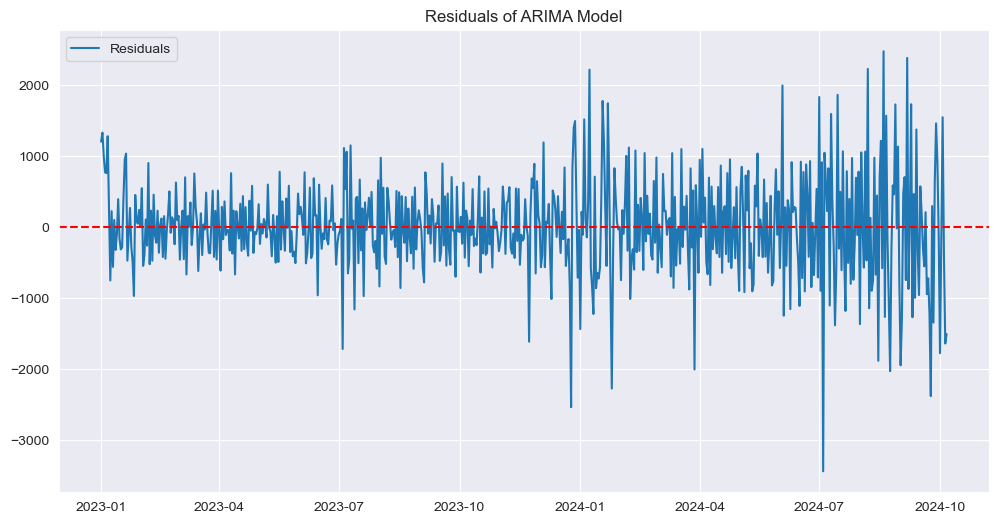

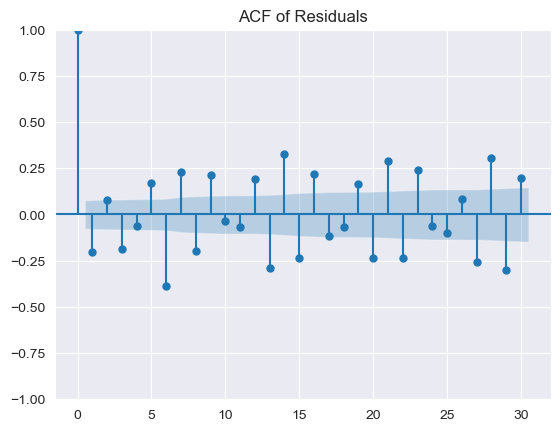

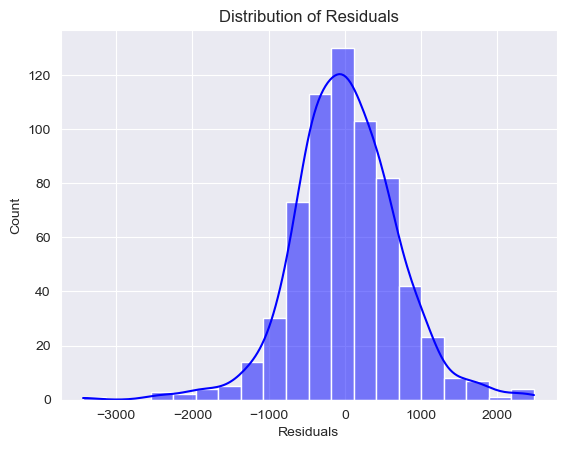

In [25]:
residuals = residual_analysis(model_fit)

In [26]:
def forecast_with_confidence_intervals(model_fit, data, forecast_steps):
    forecast_object = model_fit.get_forecast(steps=forecast_steps)

    forecast = forecast_object.predicted_mean
    conf_int = forecast_object.conf_int(alpha=0.05) 

    plt.figure(figsize=(12, 6))
    plt.plot(data, label="Historical Data")
    plt.plot(pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq="D")[1:], forecast, color="green", label="Forecast")
    plt.fill_between(pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq="D")[1:], 
                     conf_int.iloc[:, 0], conf_int.iloc[:, 1], color="green", alpha=0.2, label="95% Confidence Interval")
    plt.title("ARIMA Model Forecast with 95% Confidence Interval")
    plt.xlabel("Date")
    plt.ylabel("Number of Complaints")
    plt.legend()
    plt.grid(True)
    plt.show()

    return forecast, conf_int

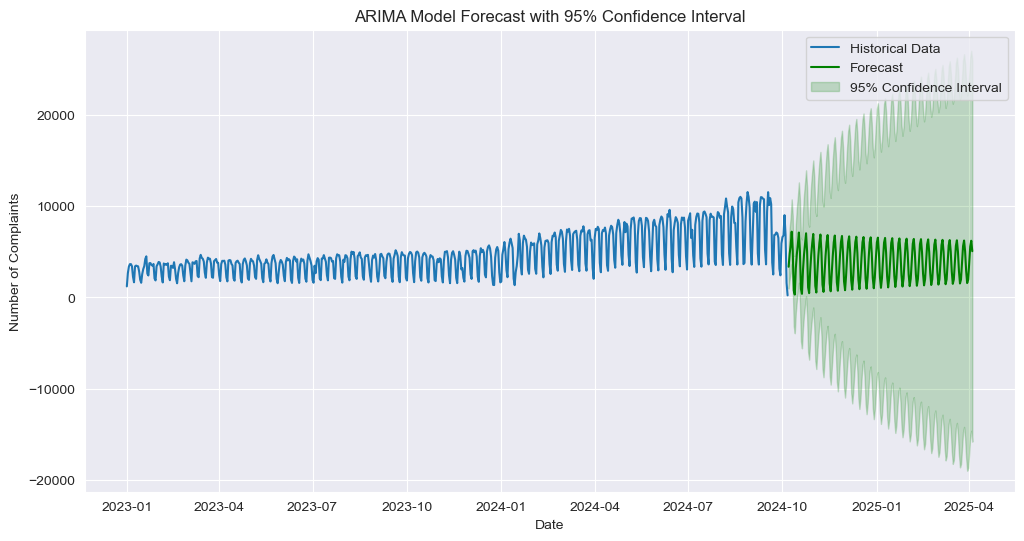

In [27]:
forecast, conf_int = forecast_with_confidence_intervals(model_fit, time_series, forecast_steps=180)

# **Baseline Prophet Model**

In [28]:
def prophet_model(data, forecast_steps):
    prophet_data = data.reset_index()
    prophet_data.columns = ['ds', 'y']

    prophet_model = Prophet()
    prophet_model.fit(prophet_data)

    future = prophet_model.make_future_dataframe(periods=forecast_steps)
    forecast = prophet_model.predict(future)

    plt.figure(figsize=(12, 6))
    prophet_model.plot(forecast, xlabel='Date', ylabel='Number of Complaints', ax=plt.gca())
    plt.title('Prophet Model Forecast (Next 6 Months)')
    plt.grid(True)
    plt.show()

    return forecast

17:17:32 - cmdstanpy - INFO - Chain [1] start processing
17:17:32 - cmdstanpy - INFO - Chain [1] done processing


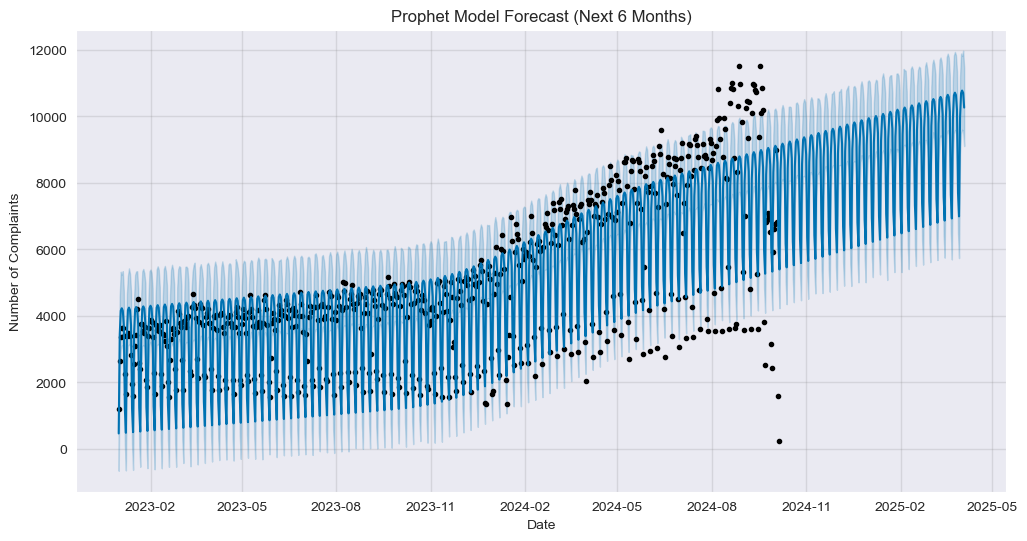

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-01-01,3044.87,-653.36,1609.02,3044.87,3044.87,-2577.12,-2577.12,-2577.12,-2577.12,-2577.12,-2577.12,0.00,0.00,0.00,467.76
1,2023-01-02,3047.56,2313.72,4598.53,3047.56,3047.56,395.38,395.38,395.38,395.38,395.38,395.38,0.00,0.00,0.00,3442.94
2,2023-01-03,3050.25,2980.72,5331.24,3050.25,3050.25,1108.49,1108.49,1108.49,1108.49,1108.49,1108.49,0.00,0.00,0.00,4158.74
3,2023-01-04,3052.94,3116.48,5246.03,3052.94,3052.94,1179.69,1179.69,1179.69,1179.69,1179.69,1179.69,0.00,0.00,0.00,4232.63
4,2023-01-05,3055.63,3081.94,5349.11,3055.63,3055.63,1100.34,1100.34,1100.34,1100.34,1100.34,1100.34,0.00,0.00,0.00,4155.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,2025-03-31,9581.59,8854.77,11207.20,9234.39,9960.30,395.38,395.38,395.38,395.38,395.38,395.38,0.00,0.00,0.00,9976.97
821,2025-04-01,9590.72,9482.49,11892.89,9241.42,9975.26,1108.49,1108.49,1108.49,1108.49,1108.49,1108.49,0.00,0.00,0.00,10699.21
822,2025-04-02,9599.84,9601.69,11821.02,9248.52,9990.16,1179.69,1179.69,1179.69,1179.69,1179.69,1179.69,0.00,0.00,0.00,10779.54
823,2025-04-03,9608.97,9572.22,11977.06,9255.05,10003.61,1100.34,1100.34,1100.34,1100.34,1100.34,1100.34,0.00,0.00,0.00,10709.31


In [29]:
prophet_model(time_series, forecast_steps=180)

# **Fine-tuned Prophet Model**

In [30]:
def fine_tune_prophet_model(data, forecast_steps, changepoint_prior_scale=0.05, seasonality_prior_scale=10, holidays=None):
    prophet_data = data.reset_index()
    prophet_data.columns = ['ds', 'y']  

    prophet_model = Prophet(interval_width=0.95,
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays=holidays,
        yearly_seasonality=True,  
        weekly_seasonality=True  
    )

    prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

    prophet_model.fit(prophet_data)

    future = prophet_model.make_future_dataframe(periods=forecast_steps)
    forecast = prophet_model.predict(future)

    plt.figure(figsize=(12, 6))
    prophet_model.plot(forecast, xlabel='Date', ylabel='Number of Complaints', ax=plt.gca())
    plt.title('Prophet Model Forecast (Next 6 Months)')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    prophet_model.plot_components(forecast)
    plt.show()

    return forecast, prophet_model
    

17:17:33 - cmdstanpy - INFO - Chain [1] start processing
17:17:33 - cmdstanpy - INFO - Chain [1] done processing


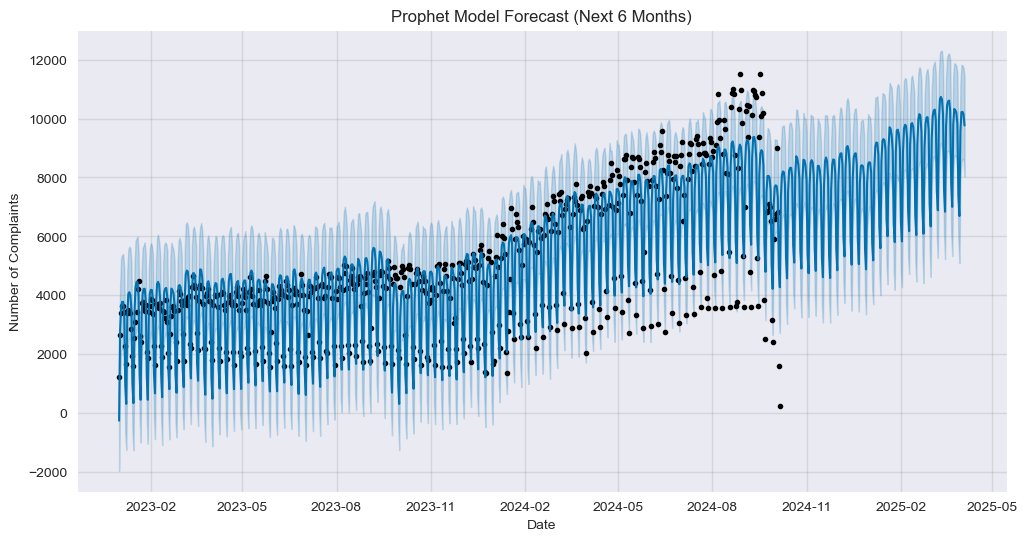

<Figure size 1200x600 with 0 Axes>

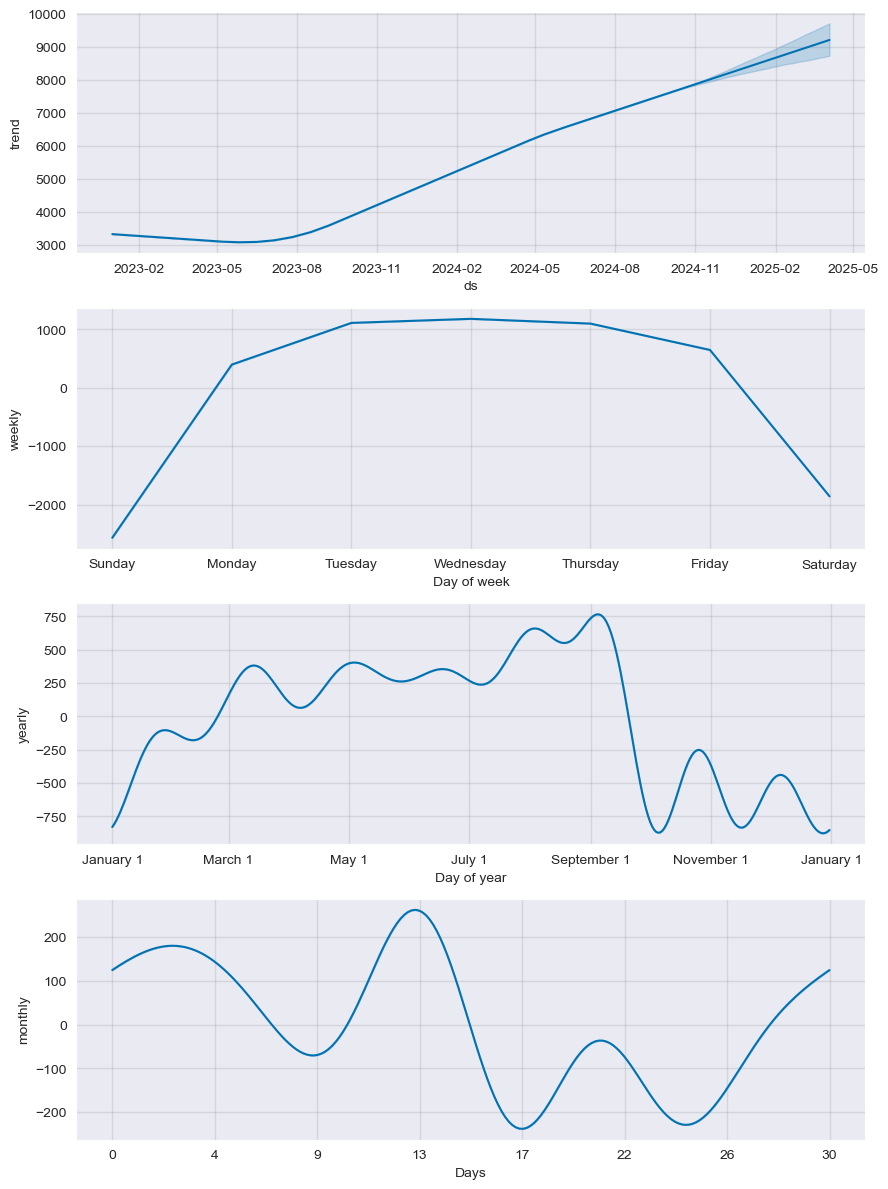

In [31]:
forecast, model = fine_tune_prophet_model(time_series, forecast_steps=180, changepoint_prior_scale=0.1, seasonality_prior_scale=15)

In [32]:
def residual_analysis_prophet(model, data): 
    data = data.reset_index()
    data.columns = ['ds', 'y']
    
    forecast = model.predict(data)
    
    residuals = data['y'] - forecast['yhat']

    plt.figure(figsize=(12, 6))
    plt.plot(residuals, label="Residuals")
    plt.axhline(0, linestyle="--", color="red")
    plt.title("Residuals of Prophet Model")
    plt.legend()
    plt.grid(True)
    plt.show()

    plot_acf(residuals, lags=30)
    plt.title("ACF of Residuals")
    plt.show()

    sns.histplot(residuals, kde=True, color="blue", bins=20)
    plt.title("Distribution of Residuals")
    plt.xlabel("Residuals")
    plt.grid(True)
    plt.show()

    return residuals

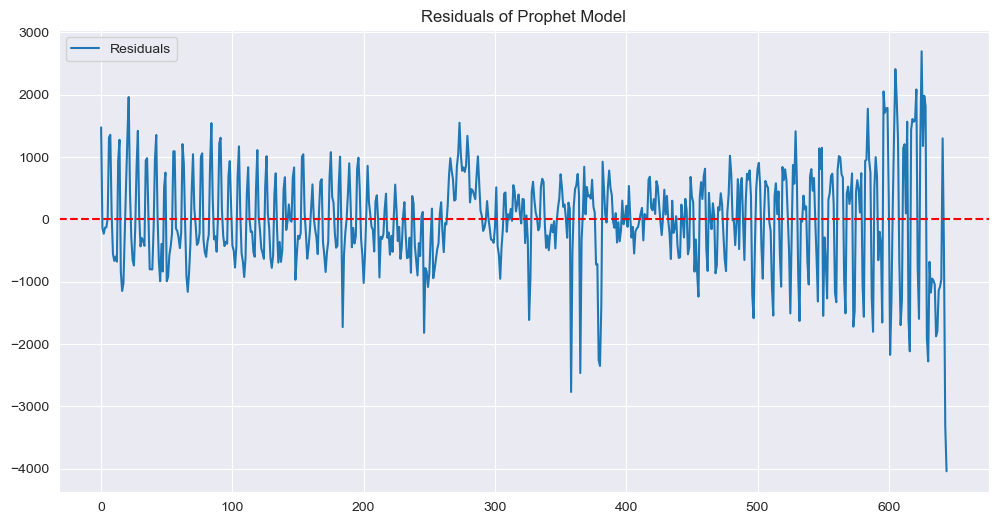

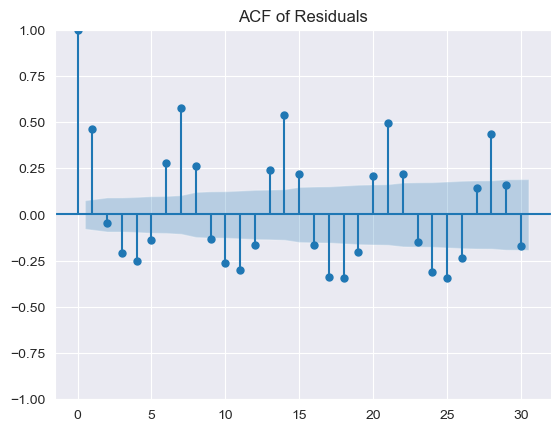

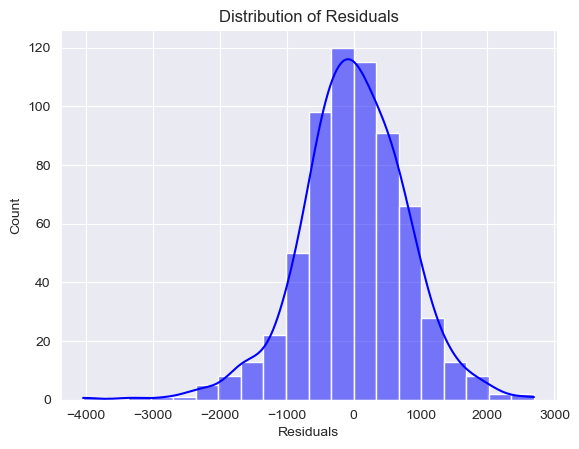

In [33]:
residuals = residual_analysis_prophet(model, time_series)

In [34]:
def forecast_with_confidence_intervals_prophet(data, forecast_steps): 
    future = model.make_future_dataframe(periods=forecast_steps)
    forecast = model.predict(future)

    historical = data.reset_index()
    historical.columns = ['ds', 'y']

    forecasted_data = forecast[forecast['ds'] > historical['ds'].max()]
    full_data = pd.concat([historical, forecast[forecast['ds'] <= historical['ds'].max()]])

    plt.figure(figsize=(12, 6))

    plt.plot(full_data['ds'], full_data['y'], label="Historical Data", color="blue")

    plt.plot(forecasted_data['ds'], forecasted_data['yhat'], label="Forecast", color="green")

    plt.fill_between(forecasted_data['ds'], forecasted_data['yhat_lower'], forecasted_data['yhat_upper'], color="green", alpha=0.2, label="95% Confidence Interval")

    plt.title("Prophet Model Forecast with 95% Confidence Interval")
    plt.xlabel("Date")
    plt.ylabel("Number of Complaints")
    plt.legend()
    plt.grid(True)
    plt.show()

    return forecast

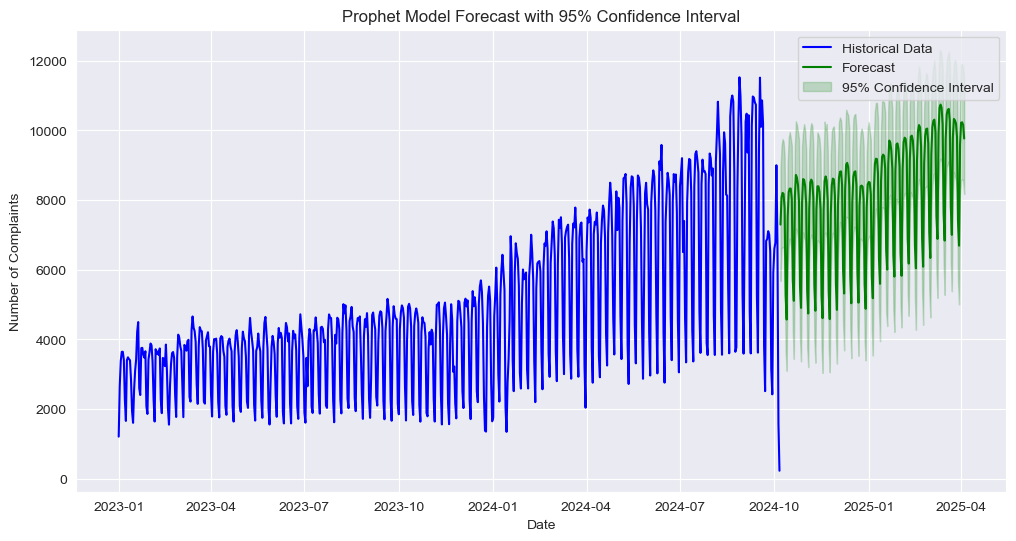

In [35]:
forecast = forecast_with_confidence_intervals_prophet(time_series, forecast_steps=180)

# **LSTM Model**

In [36]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)  
        out, _ = self.lstm(x, (h0, c0))  
        out = self.fc(out[:, -1, :])  
        return out

# **Baseline LSTM Model**

In [37]:
def lstm_model(data, n_lags, forecast_steps, hidden_size=50, num_layers=2, epochs=50, batch_size=32, learning_rate=0.001):
    print(f"Using device: {device}")

    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))

    X, y = [], []
    for i in range(n_lags, len(data_scaled)):
        X.append(data_scaled[i - n_lags:i, 0])
        y.append(data_scaled[i, 0])
    X, y = np.array(X), np.array(y)

    X_train = torch.tensor(X, dtype=torch.float32).reshape(X.shape[0], X.shape[1], 1).to(device)
    y_train = torch.tensor(y, dtype=torch.float32).to(device)

    model = LSTMModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers, output_size=1).to(device)
    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output.squeeze(), y_train)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.6f}")

    model.eval()
    last_sequence = torch.tensor(data_scaled[-n_lags:], dtype=torch.float32).reshape(1, n_lags, 1).to(device)
    forecast = []
    with torch.no_grad():
        for _ in range(forecast_steps):
            next_value = model(last_sequence)
            forecast.append(next_value.item())
            last_sequence = torch.cat((last_sequence[:, 1:, :], next_value.reshape(1, 1, 1)), dim=1)

    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()

    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data.values, label="Historical Data")
    future_dates = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='D')[1:]
    plt.plot(future_dates, forecast, label="Forecast", color="green")
    plt.title("LSTM Model Forecast (Next 6 Months)")
    plt.xlabel("Date")
    plt.ylabel("Number of Complaints")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, forecast

Using device: cuda
Epoch [10/50], Loss: 0.041386
Epoch [20/50], Loss: 0.044455
Epoch [30/50], Loss: 0.038935
Epoch [40/50], Loss: 0.037243
Epoch [50/50], Loss: 0.033540


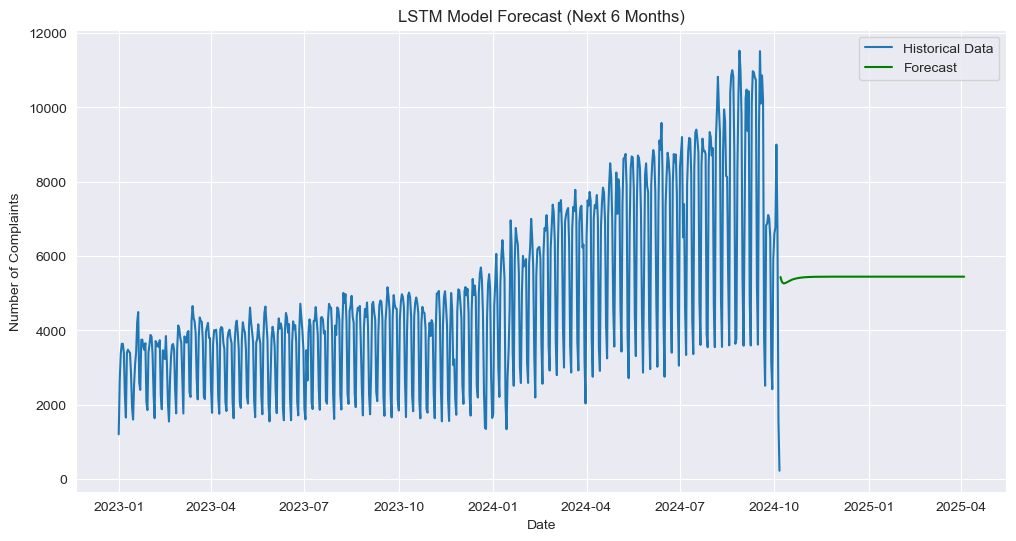

In [38]:
model, forecast = lstm_model(time_series, n_lags=30, forecast_steps=180, hidden_size=100, num_layers=2, epochs=50, batch_size=32, learning_rate=0.001)

# **Fine-tuned LSTM Model**

In [39]:
def fine_tune_lstm(data, n_lags, forecast_steps, param_grid):
    print(f"Using device: {device}")

    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))

    X, y = [], []
    for i in range(n_lags, len(data_scaled)):
        X.append(data_scaled[i - n_lags:i, 0])
        y.append(data_scaled[i, 0])
    X, y = np.array(X), np.array(y)

    X_train = torch.tensor(X, dtype=torch.float32).reshape(X.shape[0], X.shape[1], 1).to(device)
    y_train = torch.tensor(y, dtype=torch.float32).to(device)

    best_loss = float('inf')
    best_params = None
    best_model = None

    for params in ParameterGrid(param_grid):
        print(f"Training with params: {params}")
        model = LSTMModel(input_size=1, hidden_size=params['hidden_size'], num_layers=params['num_layers']).to(device)
        criterion = nn.MSELoss()
        optimizer = Adam(model.parameters(), lr=params['learning_rate'])

        model.train()
        for epoch in range(params['epochs']):
            optimizer.zero_grad()
            output = model(X_train)
            loss = criterion(output.squeeze(), y_train)
            loss.backward()
            optimizer.step()
        print(f"Final loss for params {params}: {loss.item()}")

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_params = params
            best_model = model

    print(f"Best Parameters: {best_params}, Best Loss: {best_loss}")

    best_model.eval()
    last_sequence = torch.tensor(data_scaled[-n_lags:], dtype=torch.float32).reshape(1, n_lags, 1).to(device)
    forecast = []
    with torch.no_grad():
        for _ in range(forecast_steps):
            next_value = best_model(last_sequence)
            forecast.append(next_value.item())
            last_sequence = torch.cat((last_sequence[:, 1:, :], next_value.reshape(1, 1, 1)), dim=1)

    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()

    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data.values, label="Historical Data")
    future_dates = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='D')[1:]
    plt.plot(future_dates, forecast, label="Forecast", color="green")
    plt.title("Fine-Tuned LSTM Model Forecast (Next 6 Months)")
    plt.xlabel("Date")
    plt.ylabel("Number of Complaints")
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_model, best_params, forecast

In [40]:
param_grid = {"hidden_size": [50, 100, 150], "num_layers": [1, 2, 3], "learning_rate": [0.001, 0.005], "epochs": [50, 100]}

Using device: cuda
Training with params: {'epochs': 50, 'hidden_size': 50, 'learning_rate': 0.001, 'num_layers': 1}
Final loss for params {'epochs': 50, 'hidden_size': 50, 'learning_rate': 0.001, 'num_layers': 1}: 0.03784125670790672
Training with params: {'epochs': 50, 'hidden_size': 50, 'learning_rate': 0.001, 'num_layers': 2}
Final loss for params {'epochs': 50, 'hidden_size': 50, 'learning_rate': 0.001, 'num_layers': 2}: 0.03989994153380394
Training with params: {'epochs': 50, 'hidden_size': 50, 'learning_rate': 0.001, 'num_layers': 3}
Final loss for params {'epochs': 50, 'hidden_size': 50, 'learning_rate': 0.001, 'num_layers': 3}: 0.04129761829972267
Training with params: {'epochs': 50, 'hidden_size': 50, 'learning_rate': 0.005, 'num_layers': 1}
Final loss for params {'epochs': 50, 'hidden_size': 50, 'learning_rate': 0.005, 'num_layers': 1}: 0.030460914596915245
Training with params: {'epochs': 50, 'hidden_size': 50, 'learning_rate': 0.005, 'num_layers': 2}
Final loss for params {

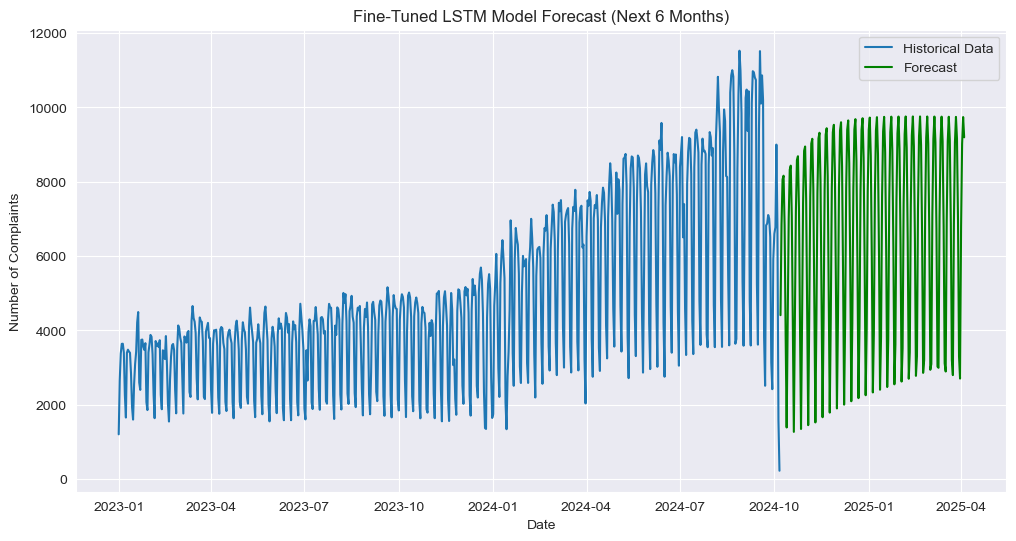

In [41]:
best_model, best_params, forecast = fine_tune_lstm(time_series, n_lags=30, forecast_steps=180, param_grid=param_grid)

In [42]:
def residual_analysis_lstm(model, data, n_lags):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))

    X, y = [], []
    for i in range(n_lags, len(data_scaled)):
        X.append(data_scaled[i - n_lags:i, 0])
        y.append(data_scaled[i, 0])
    X, y = np.array(X), np.array(y)

    X = torch.tensor(X, dtype=torch.float32).reshape(X.shape[0], X.shape[1], 1).to(device)

    model.eval()
    with torch.no_grad():
        predictions = model(X).squeeze().cpu().numpy()

    predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    actual = scaler.inverse_transform(y.reshape(-1, 1)).flatten()

    residuals = actual - predictions

    plt.figure(figsize=(12, 6))
    plt.plot(residuals, label="Residuals", color="blue")
    plt.axhline(0, linestyle="--", color="red", alpha=0.7)
    plt.title("Residuals of LSTM Model")
    plt.xlabel("Time Step")
    plt.ylabel("Residuals")
    plt.legend()
    plt.grid(True)
    plt.show()

    plot_acf(residuals, lags=30)
    plt.title("Autocorrelation of Residuals")
    plt.show()
    
    sns.histplot(residuals, kde=True, bins=30, color="blue")
    plt.title("Distribution of Residuals")
    plt.xlabel("Residuals")
    plt.grid(True)
    plt.show()

    return residuals

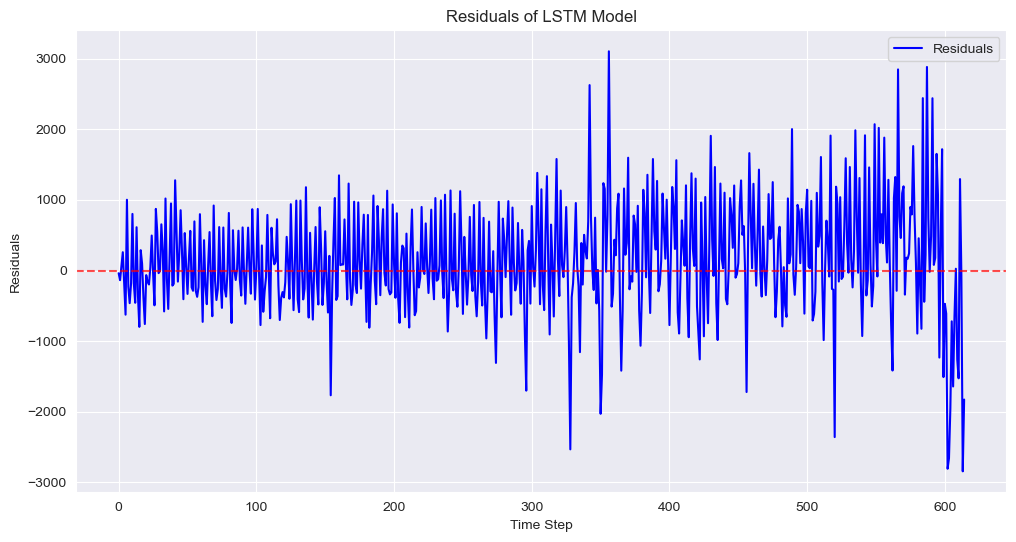

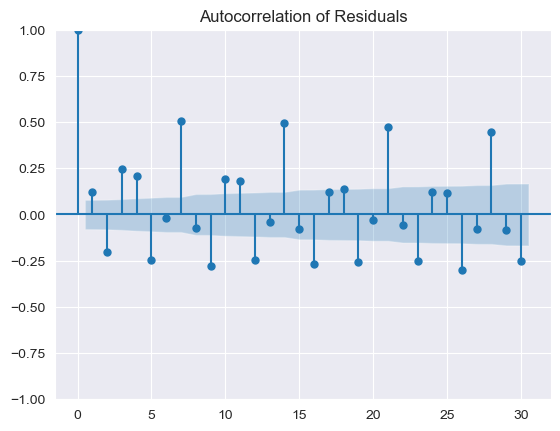

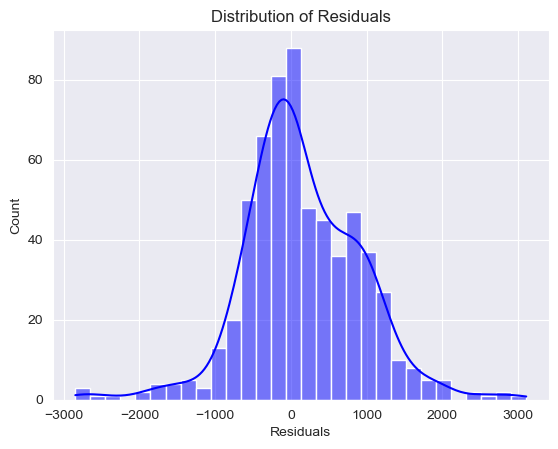

In [43]:
residuals = residual_analysis_lstm(best_model, time_series, n_lags=30)

In [46]:
def forecast_with_confidence_intervals_lstm(model, data, n_lags, forecast_steps, confidence_level=0.95):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))

    X, y = [], []
    for i in range(n_lags, len(data_scaled)):
        X.append(data_scaled[i - n_lags:i, 0])
        y.append(data_scaled[i, 0])
    X, y = np.array(X), np.array(y)

    X = torch.tensor(X, dtype=torch.float32).reshape(X.shape[0], X.shape[1], 1).to(device)

    model.eval()
    with torch.no_grad():
        predictions = model(X).squeeze().cpu().numpy()

    predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    actual = scaler.inverse_transform(y.reshape(-1, 1)).flatten()
    residuals = actual - predictions

    residual_std = np.std(residuals)

    last_sequence = torch.tensor(data_scaled[-n_lags:], dtype=torch.float32).reshape(1, n_lags, 1).to(device)
    forecast = []
    with torch.no_grad():
        for _ in range(forecast_steps):
            next_value = model(last_sequence)
            forecast.append(next_value.item())
            next_value_reshaped = np.array(next_value.cpu()).reshape(1, 1, 1)  
            last_sequence = torch.cat((last_sequence[:, 1:, :], torch.tensor(next_value_reshaped).to(device)), dim=1)

    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()

    z_score = 1.96 
    margin_of_error = z_score * residual_std
    lower_bound = forecast - margin_of_error
    upper_bound = forecast + margin_of_error

    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data.values, label="Historical Data")
    future_dates = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq="D")[1:]
    plt.plot(future_dates, forecast, label="Forecast", color="green")
    plt.fill_between(future_dates, lower_bound, upper_bound, color="green", alpha=0.2, label=f"{int(confidence_level * 100)}% Confidence Interval",)
    plt.title("LSTM Model Forecast with 95% Confidence Interval")
    plt.xlabel("Date")
    plt.ylabel("Number of Complaints")
    plt.legend()
    plt.grid(True)
    plt.show()

    return forecast


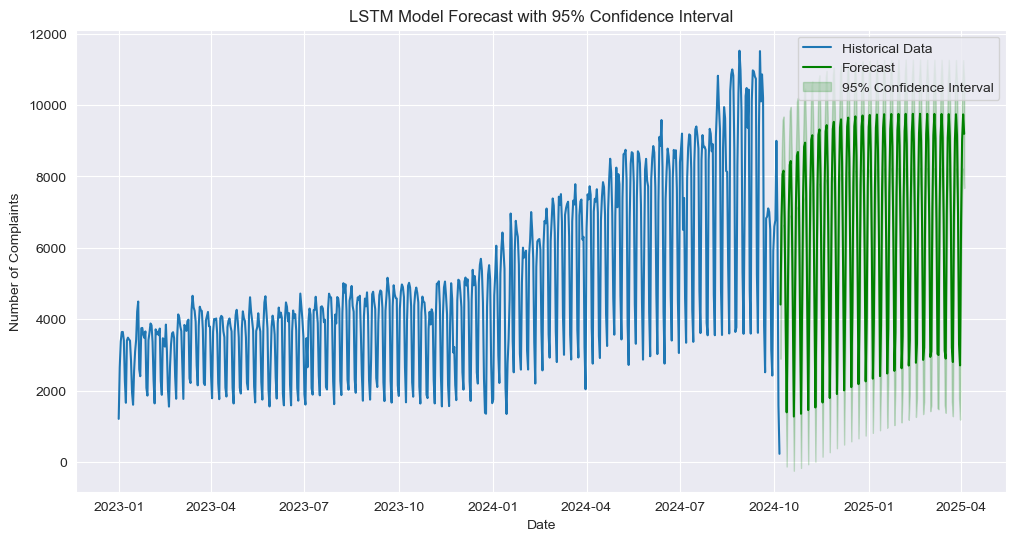

In [47]:
forecast = forecast_with_confidence_intervals_lstm(best_model, time_series, n_lags=30, forecast_steps=180, confidence_level=0.95)